**Let's build our first version of recommendation system**
## Simple Recommender.
Simple Recommender System based on the metric below:
- weightedRating(WR) = ((v/v+m).R) + ((m/v+m).C)
 * v --> is the number of votes for the movie. (vote_count)
 * m --> is the min votes required to be listed in chart. (based on negative vote)
 * R --> is the average rating of the movie. (vote_average)
 * C --> is the mean vote across the the whole report. (calculate from data)


In [1]:
import string
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
metadata = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv')
metadata.head(2)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.

  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [5]:
# Calculate mean of vote average column
C = metadata['vote_average'].mean()
C

5.618207215134185

In [6]:
# Calculate the minimum number of votes required to be in the chart, m
m = metadata['vote_count'].quantile(0.90)
m

160.0

use the `.copy()` method to ensure that the new q_movies DataFrame created is independent of your original metadata DataFrame. In other words, any changes made to the q_movies DataFrame will not affect the original metadata data frame.

In [7]:
# Filter out all qualified movies into a new DataFrame
q_movies = metadata.copy().loc[metadata['vote_count'] >= m]
q_movies.shape

(4555, 24)

In [8]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [9]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis= 1)

In [10]:
# Sort movies based on score calculated above
q_movies.sort_values(by= 'score', ascending= False, inplace= True)
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(20)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


## Recommendation system Content-Based.
**Now let's build our second version of recommendation system Content-Based Recommender.**


In [11]:
metadata['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [12]:
metadata['overview'].isnull().sum()

954

There are 539 null values in `overview` feature, so se must fill null values.

In [13]:
metadata['overview'] = metadata['overview'].fillna('')
print(metadata['overview'].isnull().sum())

0


In [14]:
tfidf = TfidfVectorizer(stop_words= 'english')
tfidf_matrix = tfidf.fit_transform(metadata['overview'])
tfidf_matrix.shape

(45466, 75827)

We see that over 75827 different words were used to describe the 45466 movies in our dataset.



In [15]:
tfidf.get_feature_names()[7000:7010]


['berthe',
 'berthelsen',
 'berthier',
 'berthold',
 'berti',
 'bertie',
 'bertier',
 'bertignac',
 'bertil',
 'bertinelli']

In [16]:
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
tfidf_matrix = tfidf_matrix[:30000] # 30000 for prevent allocate more memory than is available. It has restarted.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [17]:
cosine_sim.shape


(30000, 30000)

In [18]:
cosine_sim[1]

array([0.01504121, 1.        , 0.04681953, ..., 0.        , 0.        ,
       0.02303661])

**Each movie will be a 1 * 30000 column vector where each column will be a similarity score with each movie.**

In [19]:
indices = pd.Series(index=metadata['title'], data = metadata.index).drop_duplicates()
indices

title
Toy Story                          0
Jumanji                            1
Grumpier Old Men                   2
Waiting to Exhale                  3
Father of the Bride Part II        4
                               ...  
Subdue                         45461
Century of Birthing            45462
Betrayal                       45463
Satan Triumphant               45464
Queerama                       45465
Length: 45466, dtype: int64

In [20]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim= cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key= lambda x : x[1], reverse= True)
    
    # Get the scores of the 10 most similar movies, we stared with 1 because index 0 will give the same name of the input title 
    sim_scores = sim_scores[1:11]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 most similar movies
    return metadata['title'][movie_indices]


In [21]:
get_recommendations('The Dark Knight Rises')

12481                                      The Dark Knight
150                                         Batman Forever
1328                                        Batman Returns
15511                           Batman: Under the Red Hood
585                                                 Batman
21194    Batman Unmasked: The Psychology of the Dark Kn...
9230                    Batman Beyond: Return of the Joker
18035                                     Batman: Year One
19792              Batman: The Dark Knight Returns, Part 1
3095                          Batman: Mask of the Phantasm
Name: title, dtype: object

In [22]:
get_recommendations('The Godfather')

1178      The Godfather: Part II
1914     The Godfather: Part III
23126                 Blood Ties
11297           Household Saints
10821                   Election
17729          Short Sharp Shock
26293         Beck 28 - Familjen
8653                Violent City
13177               I Am the Law
26660                   Suddenly
Name: title, dtype: object

**Adding more features to our recommendation system.**

In [23]:
# Load keywords and credits
credits = pd.read_csv('../input/the-movies-dataset/credits.csv')
keywords = pd.read_csv('../input/the-movies-dataset/keywords.csv')

# Remove rows with bad IDs.
metadata = metadata.drop([19730, 29503, 35587])

# Convert IDs to int. Required for merging
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
metadata['id'] = metadata['id'].astype('int')

# Merge keywords and credits into your main metadata dataframe
metadata = metadata.merge(credits, on='id')
metadata = metadata.merge(keywords, on='id')
metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [26]:
# # Limit the data for memory size
metadata = metadata[:20000]

In [27]:
features = ['cast', 'crew', 'keywords', 'genres']
metadata[features].head()    

,cast,crew,keywords,genres
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'id': 35, 'name': 'Comedy'}]"


In [28]:
# Parse the striliteral_evalfied features into their corresponding python objects
from ast import literal_eval

for feature in features:
    metadata[feature] = metadata[feature].apply(literal_eval)

metadata[features].head()    

,cast,crew,keywords,genres
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'id': 35, 'name': 'Comedy'}]"


* Each one row of `crew` have a lot of dict which is here indicate to character like Directing, Writing, Screenplay, etc..
se wee need to extract each `job` will be`Driector` and 

* Each one of `cast` have a lot of dict which is here indicate to echr start with his/her playrole .. so we need to extract `name`.
* Each one of `keyword` have a lot of dict which is here indicate movie keywords, so we need to extract `name`.
* Each one of `generas` have a lot of dict which is here indicate the movies which type will follow.
 

Get the director's name from the crew feature. If the director is not listed, return NaN



In [33]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [34]:
def get_list_or_top_3(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        # get just 3 or less
        if len(names) > 3:
            names = names[:3]
        return names

    # return empty list if it missing data!
    return []

In [35]:
# Define new director
metadata['director'] = metadata['crew'].apply(get_director)
metadata.head(2)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",John Lasseter
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",Joe Johnston


In [36]:
# Define new director cast, genres and keywords features.
features = ['cast', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(get_list_or_top_3)
    
metadata[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"


In [37]:
# Function to convert all strings to lower case and strip names of spaces
def clean_text(txt):
    if isinstance(txt, list):
        return [i.replace(" ", "").lower() for i in txt]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(txt, str):
            return txt.replace(" ", "").lower()
        else:
            return ''
        

In [38]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    metadata[feature] = metadata[feature].apply(clean_text)

metadata[features].head(2)    

,cast,keywords,director,genres
0,"[tomhanks, timallen, donrickles]","[jealousy, toy, boy]",johnlasseter,"[animation, comedy, family]"
1,"[robinwilliams, jonathanhyde, kirstendunst]","[boardgame, disappearance, basedonchildren'sbook]",joejohnston,"[adventure, fantasy, family]"


In [39]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])


In [40]:
# Create a new soup feature
metadata['soup'] = metadata.apply(create_soup, axis=1)
metadata[['soup']].head()

,soup
0,jealousy toy boy tomhanks timallen donrickles ...
1,boardgame disappearance basedonchildren'sbook ...
2,fishing bestfriend duringcreditsstinger walter...
3,basedonnovel interracialrelationship singlemot...
4,baby midlifecrisis confidence stevemartin dian...


In [41]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata['soup'])
count_matrix.shape


(20000, 36429)

Next, you will use the `cosine_similarity` to measure the distance between the embeddings.



In [42]:
from sklearn.metrics.pairwise import cosine_similarity
# count_matrix = count_matrix[:30000] # 20000 for prevent allocate more memory than is available. It has restarted.
cosine_sim_2 = cosine_similarity(count_matrix, count_matrix)
cosine_sim_2.shape

(20000, 20000)

In [43]:
# Reset index of our main DataFrame and construct reverse mapping as before
metadata = metadata.reset_index()
indices = pd.Series(index=metadata['title'], data = metadata.index )
indices = pd.Series(index=metadata['title'], data = metadata.index).drop_duplicates()
indices.head()

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64

You can now reuse your `get_recommendations()` function by passing in the new `cosine_sim_2` matrix as your second argument.



In [44]:
get_recommendations('The Dark Knight Rises', cosine_sim_2)

12589      The Dark Knight
10210        Batman Begins
9311                Shiner
9874       Amongst Friends
7772              Mitchell
516      Romeo Is Bleeding
11463         The Prestige
10853       Helter Skelter
18940            Last Exit
4520       An Innocent Man
Name: title, dtype: object

In [45]:
get_recommendations('The Godfather', cosine_sim_2)

1934            The Godfather: Part III
1199             The Godfather: Part II
15609                   The Rain People
18940                         Last Exit
8001     The Night of the Following Day
18261                 The Son of No One
7772                           Mitchell
1186                     Apocalypse Now
1648                   Ill Gotten Gains
3487         Jails, Hospitals & Hip-Hop
Name: title, dtype: object

## Recommendation system Collaborative Filtering.
**Now let's build our third version of recommendation system `Collaborative Filtering` Recommender.**
 


In [46]:
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


make each row of genres as a one string, because it will work good as long as i not using the sequance.

In [47]:
movies = metadata[['id', 'title', 'genres']]
movies['genres'] =  ["".join(st) for st in movies['genres']] 
movies.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  


,id,title,genres
0,862,Toy Story,animationcomedyfamily
1,8844,Jumanji,adventurefantasyfamily
2,15602,Grumpier Old Men,romancecomedy
3,31357,Waiting to Exhale,comedydramaromance
4,11862,Father of the Bride Part II,comedy


In [48]:
pd.crosstab(ratings['userId'], movies['id']).head()

id,2,3,5,6,11,12,13,14,15,16,...,427043,429876,434306,434973,438108,440178,442417,445590,449677,458428
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are gaps in each user id and in each movie id, **It's not sequential numbers like 0,1,2,3,4 .. etc it something like 862, 8844, 15602, .. etc**, so we will use `LabelEncoder()` for making them in a sequential way like 0,1,2,3,4 .. etc.

In [49]:
encoder = LabelEncoder()
ratings['user'] = encoder.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

ratings['movie'] = encoder.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()


ratings['rating'] = ratings['rating'].values.astype(np.float32)

min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating

(671, 9066, 0.5, 5.0)

Extract the train and test data for the data

In [50]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(90003, 2) (90003,)

(10001, 2) (10001,)


**Here we make a regularization to help model generalization by `embeddings_regularizer` hyperparameter, and we should make this regularization `on all embedding tables` as a specific for avoiding `overfitting`**

Model: "model"

__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     


input_1 (InputLayer)            [(None, 1)]          0                                            

__________________________________________________________________________________________________

input_2 (InputLayer)            [(None, 1)]          0                                            

__________________________________________________________________________________________________

embedding (Embedding)           (None, 1, 50)        33550       input_1[0][0]                    

__________________________________________________________________________________________________

embedding_1 (Embedding)         (None, 1, 50)        453300      input_2[0][0]                    

___________________________________________________________________________________

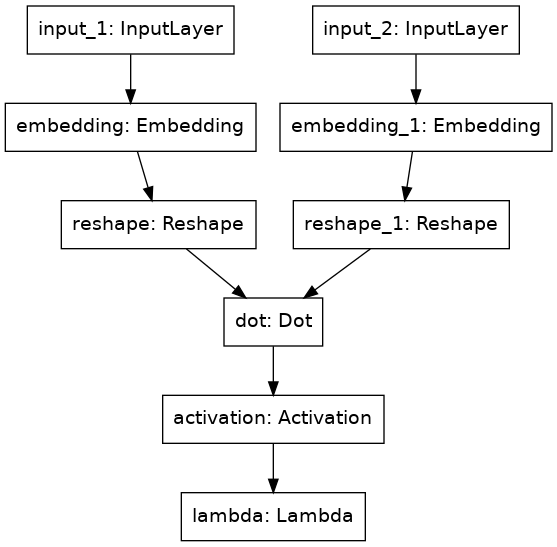

In [51]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Dot product
rating = layers.Dot(axes=1)([user_emb, movie_emb])
rating = layers.Activation('sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating) # scalling up

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse', metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
model.summary()
plot_model(model)

In [52]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5

1407/1407 [==============================] - 8s 5ms/step - loss: 1.6969 - root_mean_squared_error: 1.3021 - val_loss: 0.9985 - val_root_mean_squared_error: 0.9984

Epoch 2/5

1407/1407 [==============================] - 6s 4ms/step - loss: 0.8577 - root_mean_squared_error: 0.9248 - val_loss: 0.8308 - val_root_mean_squared_error: 0.9095

Epoch 3/5

1407/1407 [==============================] - 7s 5ms/step - loss: 0.6434 - root_mean_squared_error: 0.7997 - val_loss: 0.7972 - val_root_mean_squared_error: 0.8900

Epoch 4/5

1407/1407 [==============================] - 7s 5ms/step - loss: 0.5222 - root_mean_squared_error: 0.7189 - val_loss: 0.7884 - val_root_mean_squared_error: 0.8843

Epoch 5/5

1407/1407 [==============================] - 7s 5ms/step - loss: 0.4089 - root_mean_squared_error: 0.6341 - val_loss: 0.7933 - val_root_mean_squared_error: 0.8863


**Here also make regularization on`user_bias` and`movie_bias` embeddings layers**.

Model: "model_1"

__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     


input_3 (InputLayer)            [(None, 1)]          0                                            

__________________________________________________________________________________________________

input_4 (InputLayer)            [(None, 1)]          0                                            

__________________________________________________________________________________________________

embedding_2 (Embedding)         (None, 1, 50)        33550       input_3[0][0]                    

__________________________________________________________________________________________________

embedding_4 (Embedding)         (None, 1, 50)        453300      input_4[0][0]                    

_________________________________________________________________________________

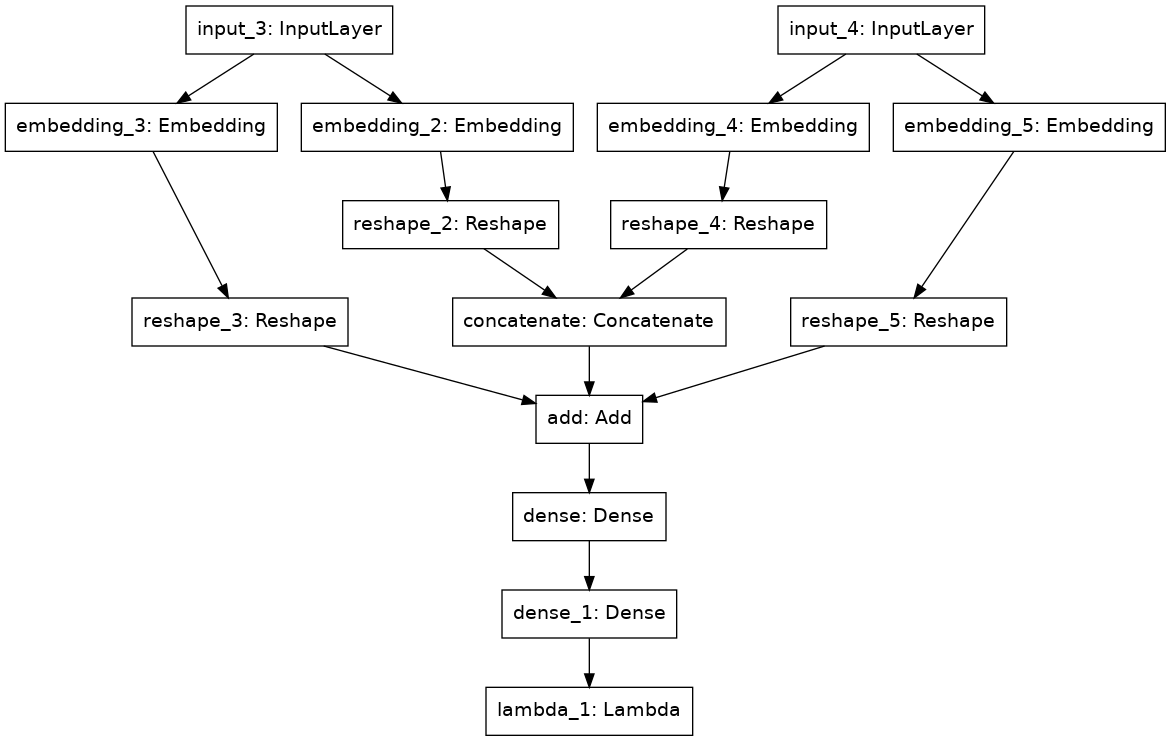

In [53]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(n_movies, 1, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Concatenate()([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Dense(10, activation='relu')(rating)
rating = layers.Dense(1, activation='sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse',  metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
print(model.summary())
plot_model(model, to_file='model.png')

In [54]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5

1407/1407 [==============================] - 8s 5ms/step - loss: 1.0441 - root_mean_squared_error: 1.0180 - val_loss: 0.7919 - val_root_mean_squared_error: 0.8896

Epoch 2/5

1407/1407 [==============================] - 7s 5ms/step - loss: 0.7170 - root_mean_squared_error: 0.8463 - val_loss: 0.7784 - val_root_mean_squared_error: 0.8817

Epoch 3/5

1407/1407 [==============================] - 7s 5ms/step - loss: 0.6585 - root_mean_squared_error: 0.8107 - val_loss: 0.7888 - val_root_mean_squared_error: 0.8873

Epoch 4/5

1407/1407 [==============================] - 6s 4ms/step - loss: 0.6167 - root_mean_squared_error: 0.7842 - val_loss: 0.7937 - val_root_mean_squared_error: 0.8898

Epoch 5/5

1407/1407 [==============================] - 6s 4ms/step - loss: 0.5902 - root_mean_squared_error: 0.7668 - val_loss: 0.8026 - val_root_mean_squared_error: 0.8945


Here `RMSE ~ 90%`